# Objective
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.

# Data Description
The data file names are:
- images.npy
- Label.csv

The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are also put into the Labels.csv.

In [1]:
PYTHONHASHSEED=0 

import numpy as np
import pandas as pd
import random

random.seed(2)
np.random.seed(597)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
tf.random.set_seed(106)
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize

from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# Import Data

In [2]:
plant = np.load("images.npy")  # import images

In [3]:
X = plant.copy()

In [4]:
X.shape

(4750, 128, 128, 3)

- The image numpy array contains 4750 images, each image is 128 x 128 x 3.

In [5]:
X[3]   # check a random image

array([[[ 49,  48,  57],
        [ 47,  48,  58],
        [ 48,  50,  56],
        ...,
        [ 48,  47,  54],
        [ 73,  69,  82],
        [ 73,  72,  82]],

       [[ 48,  49,  59],
        [ 48,  54,  58],
        [ 72,  70,  75],
        ...,
        [ 46,  48,  54],
        [ 63,  64,  67],
        [ 69,  66,  75]],

       [[ 48,  49,  60],
        [ 60,  65,  67],
        [100, 102, 106],
        ...,
        [ 36,  39,  47],
        [ 43,  44,  52],
        [ 72,  69,  80]],

       ...,

       [[ 59,  55,  60],
        [ 60,  57,  61],
        [ 62,  59,  61],
        ...,
        [ 38,  68,  86],
        [ 50,  73,  91],
        [ 39,  60,  81]],

       [[138, 135, 138],
        [169, 166, 160],
        [173, 166, 163],
        ...,
        [ 36,  58,  77],
        [ 37,  57,  83],
        [ 30,  51,  73]],

       [[121, 115, 120],
        [145, 141, 143],
        [140, 133, 135],
        ...,
        [ 33,  56,  62],
        [ 64,  80,  87],
        [ 53,  74,  85]]

In [6]:
labels = pd.read_csv("Labels.csv")    # import labels

In [7]:
y = labels.copy()

In [8]:
y.shape

(4750, 1)

In [9]:
y.sample(5)

Label
1596  Common Chickweed
504            Fat Hen
2309          Charlock
2189          Charlock
3660             Maize

In [10]:
y["Label"].nunique()

12

In [11]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


- The length of labels is 4750. The datatype is object. As the problem statement indicates, there're 12 unique classes.

# EDA

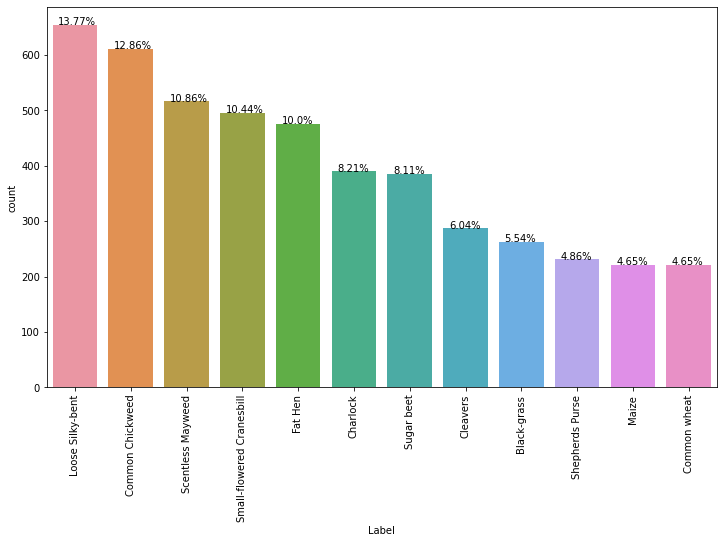

In [12]:
plt.figure(figsize = (12,7))
ax = sns.countplot(x = "Label", data = y, order =y["Label"].value_counts().index);    # countplot of labels
plt.xticks(rotation = 90);
for p in ax.patches:
    per = np.round(100 * p.get_height() / y.shape[0], 2)
    plt.annotate(str(per) + "%", (p.get_x() + p.get_width()/2 - 0.3, p.get_y() + p.get_height() + 0.1))

- The distribution of classes is not uniform. `Loose Silky-bent` accounts for 13.77% of the total, followed by `Common Chickweed` of 12.86%. `Common wheat` only accounts for 4.65%.

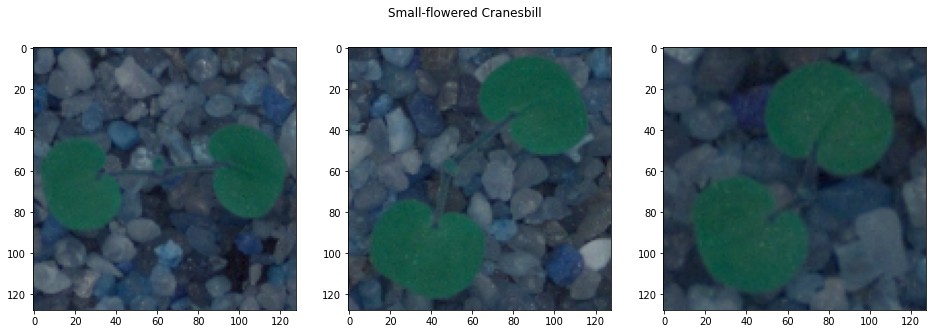

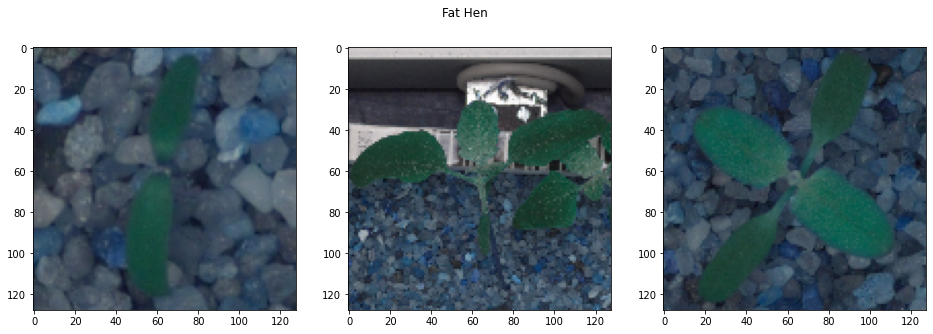

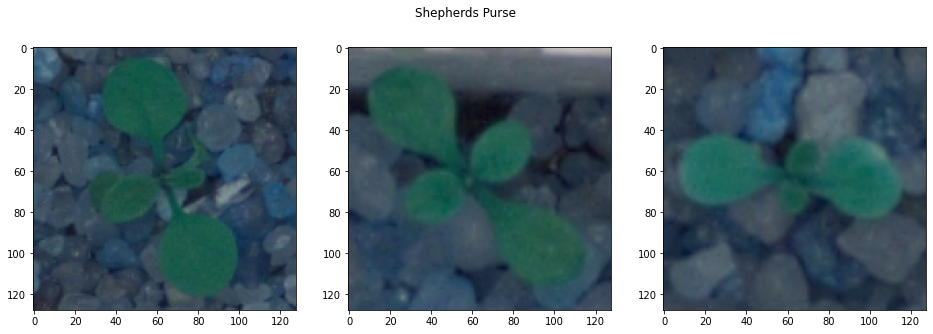

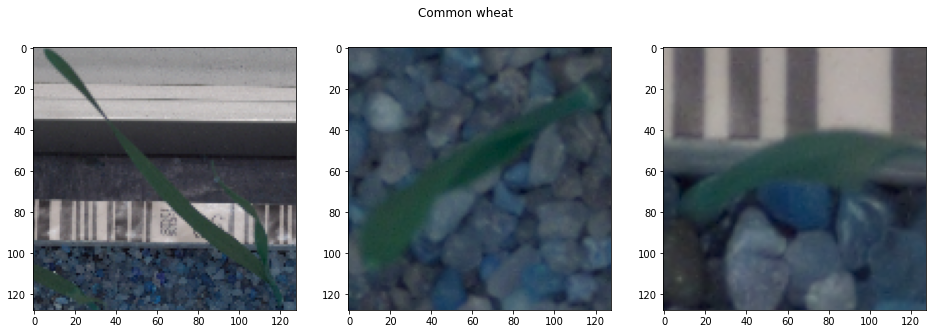

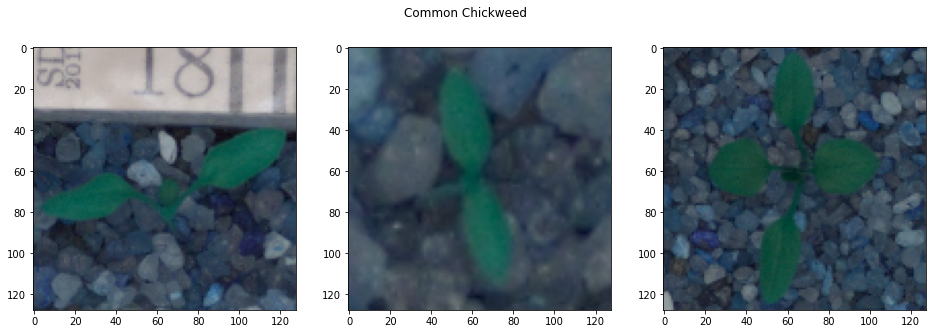

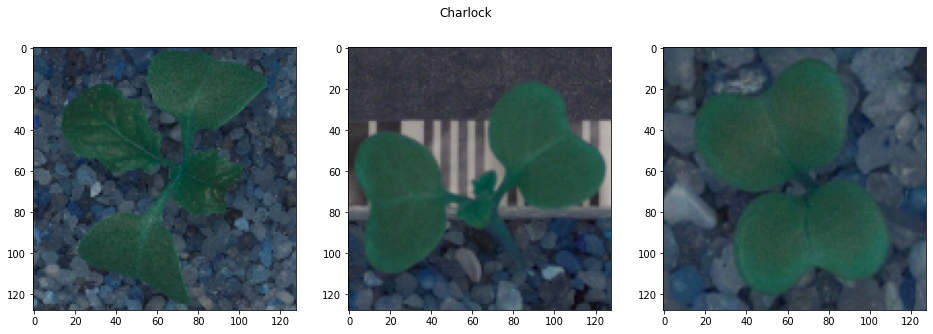

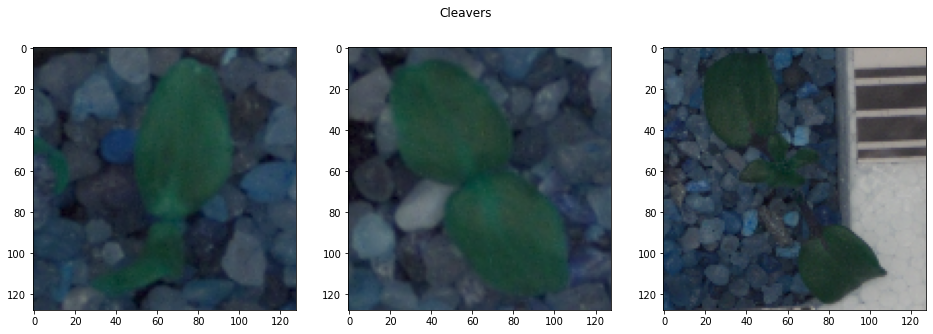

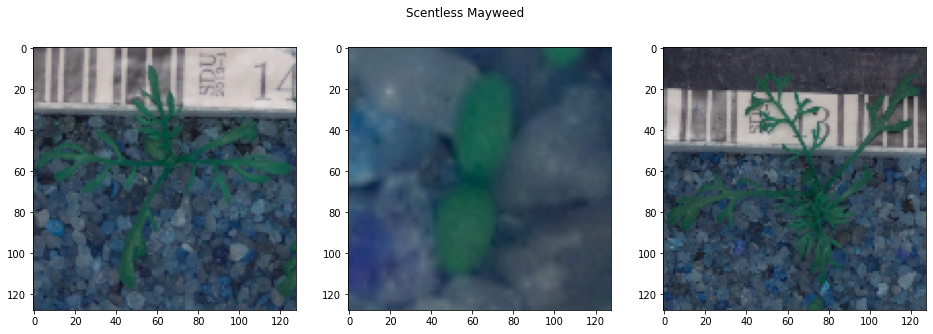

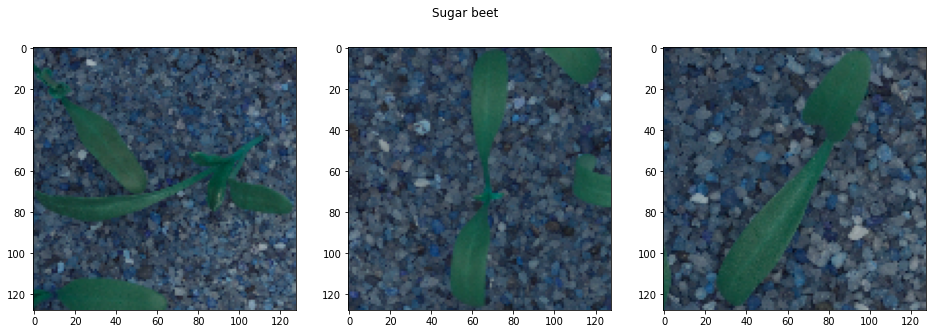

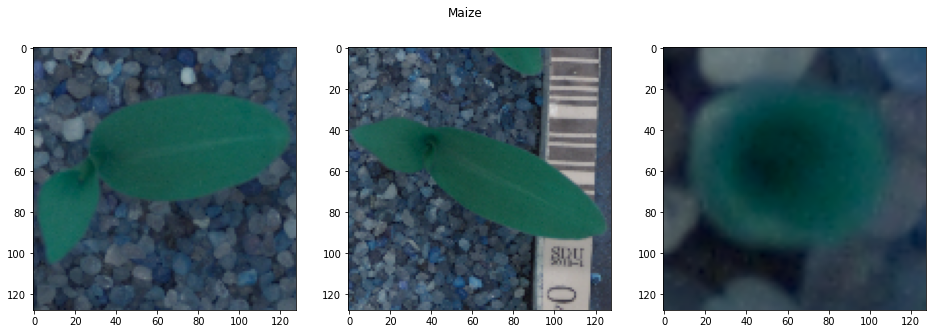

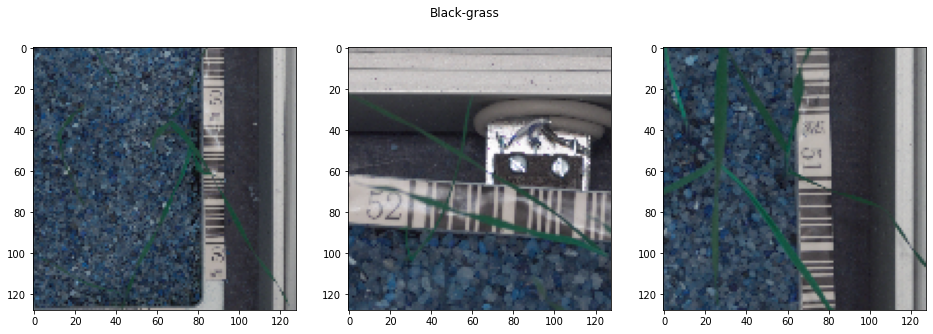

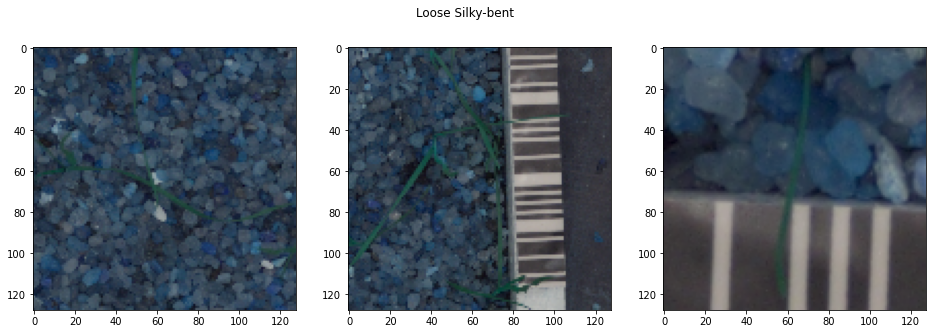

In [13]:
# Plot the images from each class and print their corresponding labels
for label in y["Label"].unique():
    idx = y[y.Label == label].index 
    plt.figure(figsize=(16,5))   # display 3 images for each class
    plt.subplot(131)
    plt.imshow(X[idx[0]]);
    plt.subplot(132)
    plt.imshow(X[idx[100]]);    
    plt.subplot(133)
    plt.imshow(X[idx[200]]);    
    plt.suptitle(label); 


- The images are colored. Width and height are both 128, with 3 channels.
- Some images are very blurry.

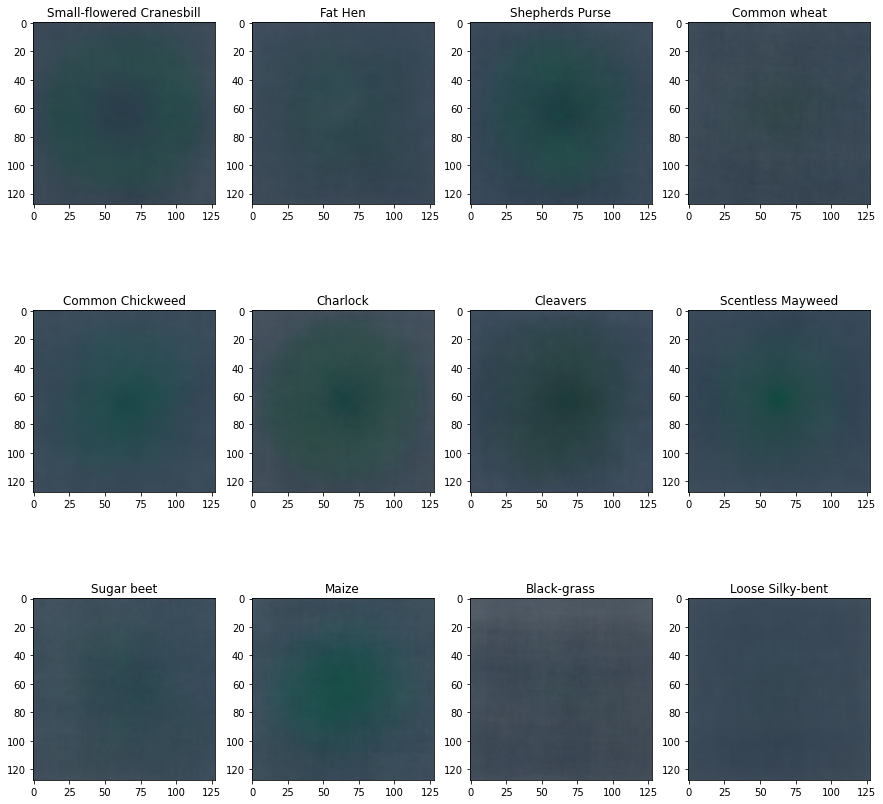

In [14]:
# Plot the mean images for each class
plt.figure(figsize = (15,15))
for i, label in enumerate(y["Label"].unique()):
    idx = y[y.Label == label].index # indices of images corresponding to this class
    idx = np.array(idx)
    mean_img = np.mean(X[idx], axis = 0)
    mean_img = np.round(mean_img).astype("int32")

    plt.subplot(3, 4, i + 1)
    plt.imshow(mean_img);
    plt.title(label);

- The mean images show different intensity patterns for each class.
- The background color which is blue gray, and the plants which are green, are kind of blended and hard to tell apart.

# Data Pre-processing

In [15]:
X1 = X.copy()
y1 = y.copy()

## Gaussian Blurring
Apply gaussian blurring with a kernel of 13 x 13, standard deviation of 0, to smooth the images and reduce noise.

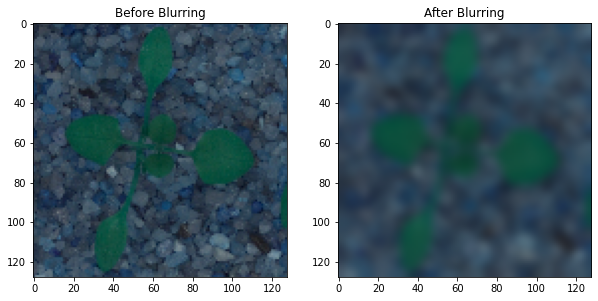

In [16]:
i = 1938   # check a random image after blurring, compare before and after side by side

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(X1[i])
plt.title("Before Blurring");

for j in range(len(X)):
    X1[j] = cv2.GaussianBlur(src = X1[j], ksize = (13,13), sigmaX = 0)
    
plt.subplot(122)
plt.imshow(X1[i])
plt.title("After Blurring");

## Normalization

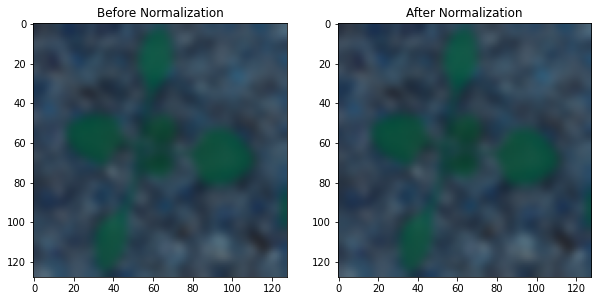

In [17]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(X1[i])
plt.title("Before Normalization");

X1 = X1.astype("float32") / 255.0

plt.subplot(122)
plt.imshow(X1[i])    # plt.imshow() does denormalization internally
plt.title("After Normalization");

In [18]:
print("maximum after blurring:", X1.max())
print("minimum after blurring:", X1.min())

maximum after blurring: 0.98039216
minimum after blurring: 0.0


## Split Data

In [19]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 11, stratify = y1, shuffle = True)
X1_test, X1_valid, y1_test, y1_valid= train_test_split(X1_test, y1_test, test_size = 0.5, random_state = 6, stratify = y1_test, shuffle = True)
print("Train: ", X1_train.shape, y1_train.shape)
print("Validation: ", X1_valid.shape, y1_valid.shape)
print("Test: ", X1_test.shape, y1_test.shape)

Train:  (3325, 128, 128, 3) (3325, 1)
Validation:  (713, 128, 128, 3) (713, 1)
Test:  (712, 128, 128, 3) (712, 1)


## Convert Labels to One-hot Encoding

In [20]:
y1_train = pd.get_dummies(y1_train)
y1_valid = pd.get_dummies(y1_valid)
y1_test = pd.get_dummies(y1_test)
y1_train.head()

Label_Black-grass  Label_Charlock  Label_Cleavers  \
4275                  0               0               0   
4053                  1               0               0   
1286                  0               0               0   
2286                  0               1               0   
4239                  0               0               0   

      Label_Common Chickweed  Label_Common wheat  Label_Fat Hen  \
4275                       0                   0              0   
4053                       0                   0              0   
1286                       0                   1              0   
2286                       0                   0              0   
4239                       0                   0              0   

      Label_Loose Silky-bent  Label_Maize  Label_Scentless Mayweed  \
4275                       1            0                        0   
4053                       0            0                        0   
1286                       0            0                        0   
2286                       0            0                        0   
4239                       1            0                        0   

      Label_Shepherds Purse  Label_Small-flowered Cranesbill  Label_Sugar beet  
4275                      0                                0                 0  
4053                      0                                0                 0  
1286                      0                                0                 0  
2286                      0                                0                 0  
4239                      0                                0                 0

# Model Building

In [21]:
num_class = y.Label.nunique()
input_shape = X1_train.shape[1:]
print("number of class: ", num_class)
print("shape of each image: ", input_shape)

number of class:  12
shape of each image:  (128, 128, 3)


In [22]:
def history_loss(history):
    """
    Plot training history.
    """
    plt.figure(figsize = (20,5));

    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

In [23]:
def show_confusion_matrix(y_true, y_pred, labels = y1_train.columns.to_list()):
    """
    Show confusion matrix as heatmap.
    
    Input:
    y_true: ground truth of class.
    y_pred: predicted class.
    labels: class labels.
    
    Return:
    None.
    """
    matrix = confusion_matrix(y_true, y_pred)
    matrix_df = pd.DataFrame(matrix, columns = labels, index = labels)
    
    plt.figure(figsize = (8,7))
    sns.heatmap(matrix_df, annot = True, xticklabels = labels, yticklabels = labels, fmt='', cmap = "YlGnBu")
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

In [24]:
def visualize_prediction(model, y_true, y_pred, X_test):
    """
    Visualize some randomly chosen test images.
    """
    indices = [2, 3, 33, 36, 59, 700]
    plt.figure(figsize = (16, 9)) 
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title("Actual:" + str(y_true[idx]) + ", Predict: " + str(y_pred[idx]))

## Basic Model

In [25]:
def build_model_basic():
    model = keras.Sequential()
    # 1st conv + max pooling
    model.add(Conv2D(filters = 64, kernel_size = 3, input_shape = input_shape, strides=1, padding='same', activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # 2nd conv + max pooling
    model.add(Conv2D(filters = 64, kernel_size = 5, strides=1, padding='same', activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 3rd conv + max pooling
    model.add(Conv2D(filters = 64, kernel_size = 5, strides=1, padding='valid', activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # flatten the output of Conv
    model.add(Flatten())
    
    # fully connected NN with softmax output 
    model.add(Dense(units = 256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Dense(units = num_class, activation = "softmax", kernel_initializer="glorot_normal"))
    
    # compile with adam as optimizer and accuracy as metrics
    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [26]:
m1 = build_model_basic()
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [27]:
es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
cp = ModelCheckpoint(filepath = "m1.h5", monitor = "val_accuracy", mode = "max", save_best_only = True)
history = m1.fit(x = X1_train,y = y1_train, epochs = 50, verbose = 1, validation_data = (X1_valid, y1_valid), callbacks=[es, cp])

Epoch 1/50
104/104 [==============================] - 105s 1s/step - loss: 1.8025 - accuracy: 0.4069 - val_loss: 3.0800 - val_accuracy: 0.3282
Epoch 2/50
104/104 [==============================] - 108s 1s/step - loss: 1.0910 - accuracy: 0.6298 - val_loss: 2.3228 - val_accuracy: 0.3604
Epoch 3/50
104/104 [==============================] - 107s 1s/step - loss: 0.8368 - accuracy: 0.7158 - val_loss: 1.5162 - val_accuracy: 0.5372
Epoch 4/50
104/104 [==============================] - 107s 1s/step - loss: 0.6448 - accuracy: 0.7916 - val_loss: 1.3779 - val_accuracy: 0.5764
Epoch 5/50
104/104 [==============================] - 112s 1s/step - loss: 0.4965 - accuracy: 0.8376 - val_loss: 1.5670 - val_accuracy: 0.5778
Epoch 6/50
104/104 [==============================] - 107s 1s/step - loss: 0.4189 - accuracy: 0.8583 - val_loss: 1.0390 - val_accuracy: 0.7041
Epoch 7/50
104/104 [==============================] - 105s 1s/step - loss: 0.3122 - accuracy: 0.9002 - val_loss: 1.2978 - val_accuracy: 0.5750

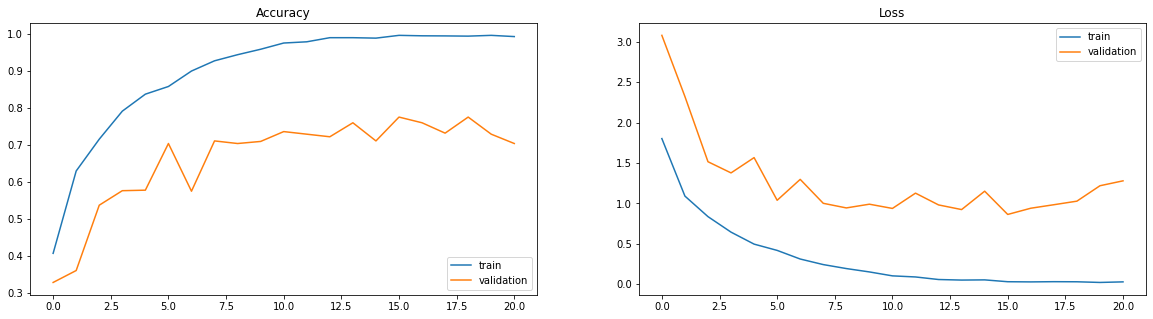

In [28]:
history_loss(history)

In [29]:
m1.load_weights("m1.h5")
m1.evaluate(X1_train, y1_train)
m1.evaluate(X1_valid, y1_valid)
m1.evaluate(X1_test, y1_test)

23/23 [==============================] - 6s 253ms/step - loss: 0.7628 - accuracy: 0.7992


[0.7627630233764648, 0.7991573214530945]

- Aftere 5 epochs, accuracy curve and loss curve kind of flatten. Overfitting exists between the train set and validation/ test set. 

In [30]:
y1_true = np.argmax(y1_test.to_numpy(), axis = -1)   # convert one-hot output to label index of the ground truth

y1_pred = m1.predict(X1_test)
y1_pred = np.argmax(y1_pred, axis = -1)   # convert one-hot output to label index

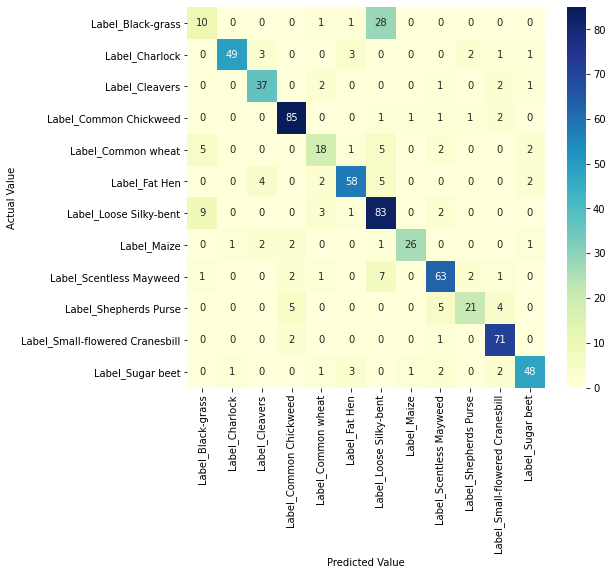

In [31]:
show_confusion_matrix(y1_true, y1_pred)

In [32]:
print(classification_report(y1_true, y1_pred))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31        40
           1       0.96      0.83      0.89        59
           2       0.80      0.86      0.83        43
           3       0.89      0.93      0.91        91
           4       0.64      0.55      0.59        33
           5       0.87      0.82      0.84        71
           6       0.64      0.85      0.73        98
           7       0.93      0.79      0.85        33
           8       0.82      0.82      0.82        77
           9       0.81      0.60      0.69        35
          10       0.86      0.96      0.90        74
          11       0.87      0.83      0.85        58

    accuracy                           0.80       712
   macro avg       0.79      0.76      0.77       712
weighted avg       0.80      0.80      0.79       712



- The metric we care about is recall. Based on the confusion matrix and classfification report, recalls for most categories are greater than 0.7, except for 3 categories (class 0, 4, 9).
- Test accuracy is 0.80, which could be further improved.

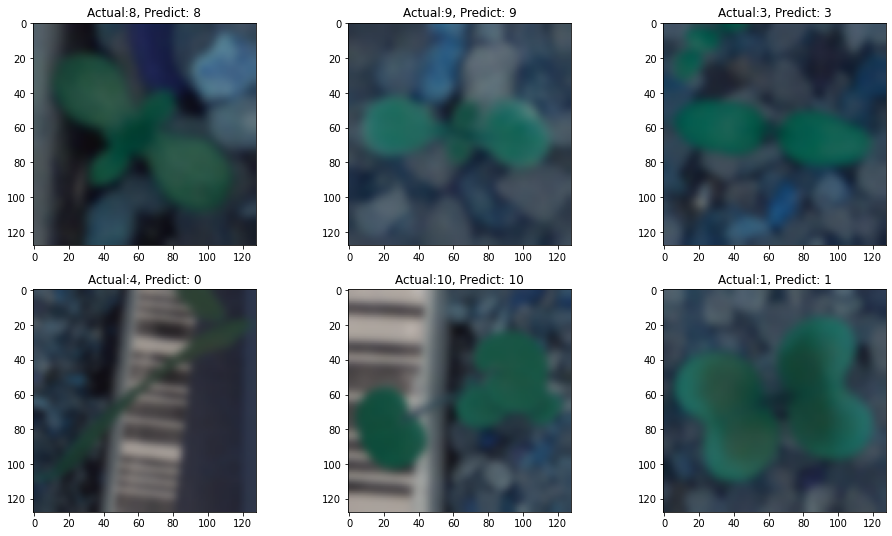

In [33]:
visualize_prediction(m1, y1_true, y1_pred, X1_test)

## Data Augmentation

- To reduce overfitting, use ImageDataGenerator to generate artifical training data to train the same model.

In [34]:
ig = ImageDataGenerator(rotation_range = 90, shear_range = 0.4, zoom_range = 0.4, horizontal_flip=True, vertical_flip=True) 

In [35]:
m2 = build_model_basic()
es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
cp = ModelCheckpoint(filepath = "m2.h5", monitor = "val_accuracy", mode = "max", save_best_only = True)

history = m2.fit(x = ig.flow(X1_train, y1_train, seed = 6), epochs = 50, verbose = 1, validation_data = (X1_valid, y1_valid), 
                 callbacks=[es, cp])   # train with augmented data and validate with original data

Epoch 1/50
104/104 [==============================] - 110s 1s/step - loss: 1.9238 - accuracy: 0.3705 - val_loss: 3.5694 - val_accuracy: 0.2090
Epoch 2/50
104/104 [==============================] - 114s 1s/step - loss: 1.4233 - accuracy: 0.5176 - val_loss: 1.7472 - val_accuracy: 0.4867
Epoch 3/50
104/104 [==============================] - 110s 1s/step - loss: 1.2370 - accuracy: 0.5859 - val_loss: 1.5087 - val_accuracy: 0.5736
Epoch 4/50
104/104 [==============================] - 109s 1s/step - loss: 1.0804 - accuracy: 0.6424 - val_loss: 1.1051 - val_accuracy: 0.6045
Epoch 5/50
104/104 [==============================] - 110s 1s/step - loss: 0.9841 - accuracy: 0.6680 - val_loss: 1.1146 - val_accuracy: 0.6269
Epoch 6/50
104/104 [==============================] - 111s 1s/step - loss: 0.9112 - accuracy: 0.6941 - val_loss: 1.1663 - val_accuracy: 0.5750
Epoch 7/50
104/104 [==============================] - 117s 1s/step - loss: 0.8187 - accuracy: 0.7257 - val_loss: 1.0665 - val_accuracy: 0.6466

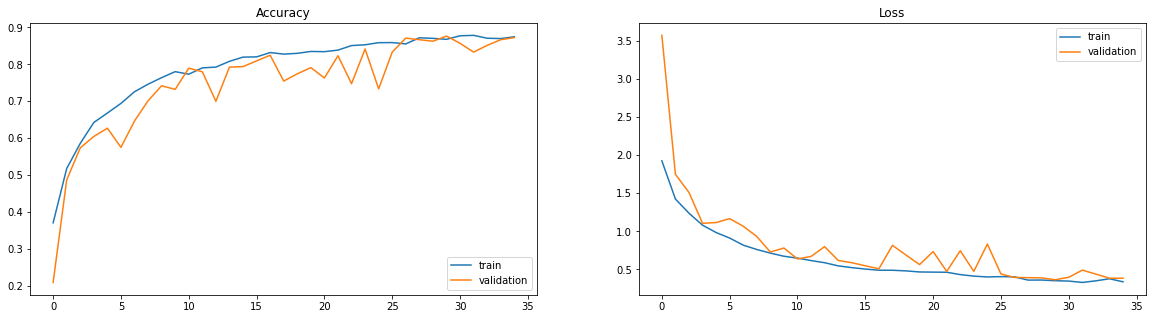

In [36]:
history_loss(history)

In [37]:
m2.load_weights("m2.h5")
m2.evaluate(X1_train, y1_train)
m2.evaluate(X1_valid, y1_valid)
m2.evaluate(X1_test, y1_test)

23/23 [==============================] - 6s 252ms/step - loss: 0.3380 - accuracy: 0.8904


[0.33804598450660706, 0.8904494643211365]

- No more overfitting. Accuracy of train/ validation/ test set are alike.

In [38]:
y1_pred = m2.predict(X1_test)
y1_pred = np.argmax(y1_pred, axis = -1)   # convert one-hot output to label index

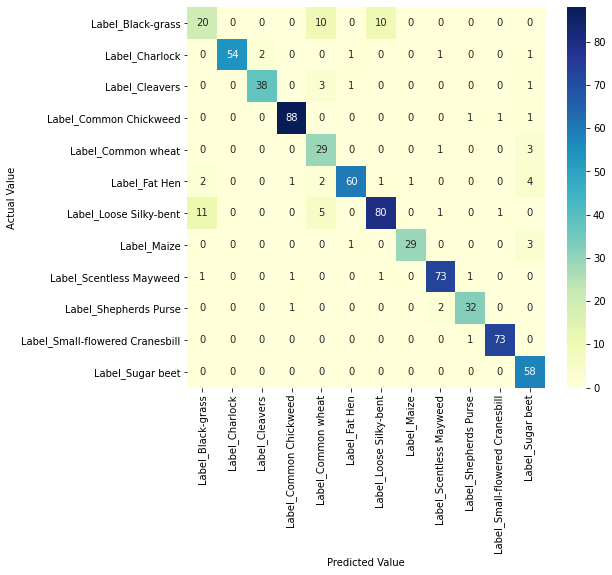

In [39]:
show_confusion_matrix(y1_true, y1_pred)

In [40]:
print(classification_report(y1_true, y1_pred))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54        40
           1       1.00      0.92      0.96        59
           2       0.95      0.88      0.92        43
           3       0.97      0.97      0.97        91
           4       0.59      0.88      0.71        33
           5       0.95      0.85      0.90        71
           6       0.87      0.82      0.84        98
           7       0.97      0.88      0.92        33
           8       0.94      0.95      0.94        77
           9       0.91      0.91      0.91        35
          10       0.97      0.99      0.98        74
          11       0.82      1.00      0.90        58

    accuracy                           0.89       712
   macro avg       0.88      0.88      0.87       712
weighted avg       0.90      0.89      0.89       712



- Accuracy is improved to 0.89 from 0.80.
- The number of categories with bad recall is reduced: only one category (class 0) gains recall below 0.70. Even this recall is improved compared to model m1.

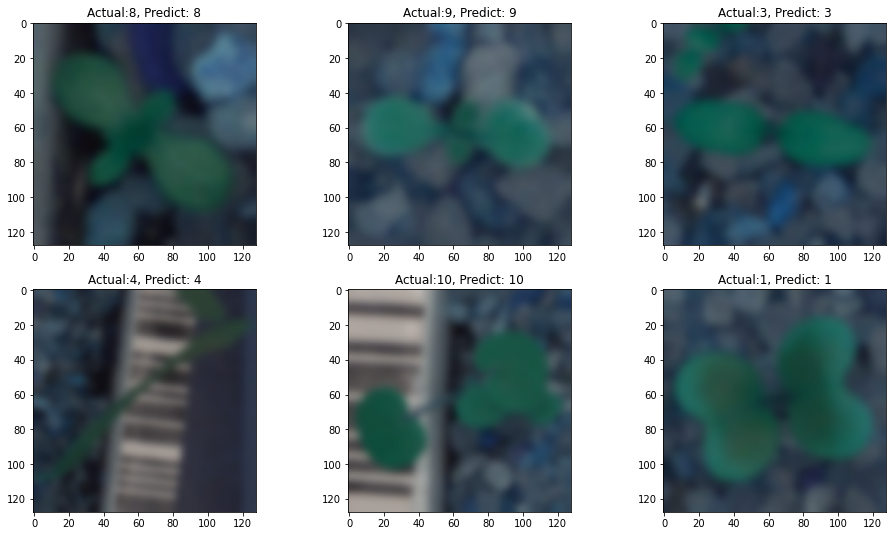

In [41]:
visualize_prediction(m2, y1_true, y1_pred, X1_test)

## Transfer Learning and Data Augmentation
- Fine tune a pre-trained model (here we choose InceptionV3) and combine it with data augmentation.

In [42]:
InceptionV3(include_top=True, weights='imagenet').summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 149, 149, 32) 96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 149, 149, 32) 0           batch_normalization_2[0][0]      
_______________________________________________________________________________________

conv2d_89 (Conv2D)              (None, 8, 8, 384)    442368      activation_83[0][0]              
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 8, 8, 1280)   0           mixed8[0][0]                     
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 8, 8, 320)    409600      mixed8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 8, 8, 384)    1152        conv2d_84[0][0]                  
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 8, 8, 384)    1152        conv2d_85[0][0]                  
__________________________________________________________________________________________________
batch_norm

- InceptionV3 expects the inputs between -1 and 1. Before feeding data into the pre-trained model, need to call the corresponding pre-process method to transform the data.

In [43]:
X2 = X.copy()
y2 = y.copy()

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 11, stratify = y2, shuffle = True)
X2_test, X2_valid, y2_test, y2_valid= train_test_split(X2_test, y2_test, test_size = 0.5, random_state = 6, stratify = y2_test, shuffle = True)

# must pre-process inputs with preprocess_input() before feed them into the pre-trained model
X2_train = preprocess_input(X2_train)
X2_valid = preprocess_input(X2_valid)
X2_test = preprocess_input(X2_test)

# convert to one-hot encoding
y2_train = pd.get_dummies(y2_train)
y2_valid = pd.get_dummies(y2_valid)
y2_test = pd.get_dummies(y2_test)

In [44]:
print("After pre process, maximum of X2_train: ", np.max(X2_train), ", minimum of X2_train: ", np.min(X2_train))

After pre process, maximum of X2_train:  1.0 , minimum of X2_train:  -1.0


In [45]:
def build_model_transfer():
    model = keras.Sequential()
    # use the architecture of InceptionV3 as feature extractor, pre-trained weights as initializer
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape, pooling = "avg")
    model.add(Model(inputs=base_model.input,outputs = base_model.layers[-2].output))
        
    # flatten the output of Conv
    model.add(Flatten())
    
    # fully connected NN with softmax output 
    model.add(Dense(units = 256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(Dense(units = num_class, activation = "softmax", kernel_initializer="glorot_normal"))

    # compile with adam as optimizer and accuracy as metrics. 
    # because it's a fine tuning, learning rate must set to a smaller value to avoid overshooting the optimum
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [46]:
m3 = build_model_transfer()
m3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_190 (Bat (None, 256)               1024      
_________________________________________________________________
activation_190 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)               

In [47]:
es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
cp = ModelCheckpoint(filepath = "m3.h5", monitor = "val_accuracy", mode = "max", save_best_only = True)

history = m3.fit(x = ig.flow(X2_train, y2_train, seed = 6), epochs = 50, verbose = 1, validation_data = (X2_valid, y2_valid), callbacks = [es, cp]) 

Epoch 1/50
104/104 [==============================] - 171s 2s/step - loss: 2.2162 - accuracy: 0.2998 - val_loss: 1.5495 - val_accuracy: 0.5302
Epoch 2/50
104/104 [==============================] - 176s 2s/step - loss: 1.3417 - accuracy: 0.5588 - val_loss: 0.9351 - val_accuracy: 0.7097
Epoch 3/50
104/104 [==============================] - 171s 2s/step - loss: 0.8547 - accuracy: 0.7197 - val_loss: 0.6214 - val_accuracy: 0.7924
Epoch 4/50
104/104 [==============================] - 177s 2s/step - loss: 0.6327 - accuracy: 0.7874 - val_loss: 0.5484 - val_accuracy: 0.7952
Epoch 5/50
104/104 [==============================] - 167s 2s/step - loss: 0.5315 - accuracy: 0.8205 - val_loss: 0.4278 - val_accuracy: 0.8499
Epoch 6/50
104/104 [==============================] - 165s 2s/step - loss: 0.4694 - accuracy: 0.8355 - val_loss: 0.4124 - val_accuracy: 0.8555
Epoch 7/50
104/104 [==============================] - 166s 2s/step - loss: 0.3843 - accuracy: 0.8644 - val_loss: 0.3445 - val_accuracy: 0.8710

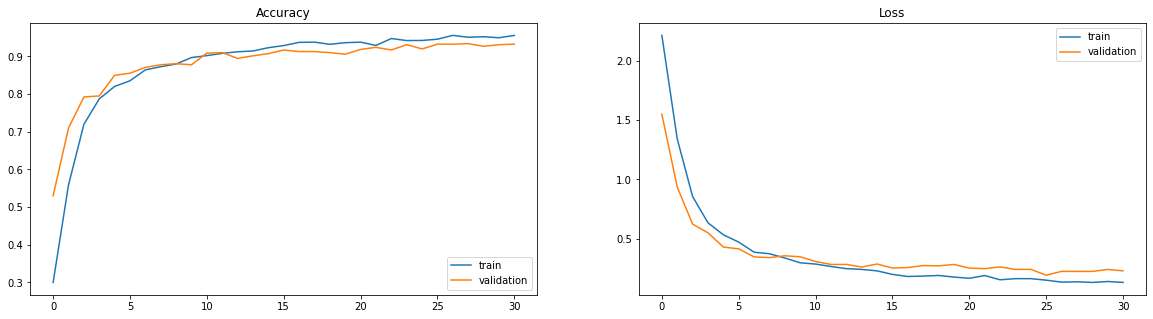

In [48]:
history_loss(history)

In [49]:
m3.load_weights("m3.h5")
m3.evaluate(X2_train, y2_train)
m3.evaluate(X2_valid, y2_valid)
m3.evaluate(X2_test, y2_test)

23/23 [==============================] - 6s 251ms/step - loss: 0.2013 - accuracy: 0.9354


[0.20132341980934143, 0.9353932738304138]

- No overfitting. Learning curve is steeper than previous models.

In [50]:
y2_true = np.argmax(y2_test.to_numpy(), axis = -1) 

y2_pred = m3.predict(X2_test)
y2_pred = np.argmax(y2_pred, axis = -1)   # convert one-hot output to label index

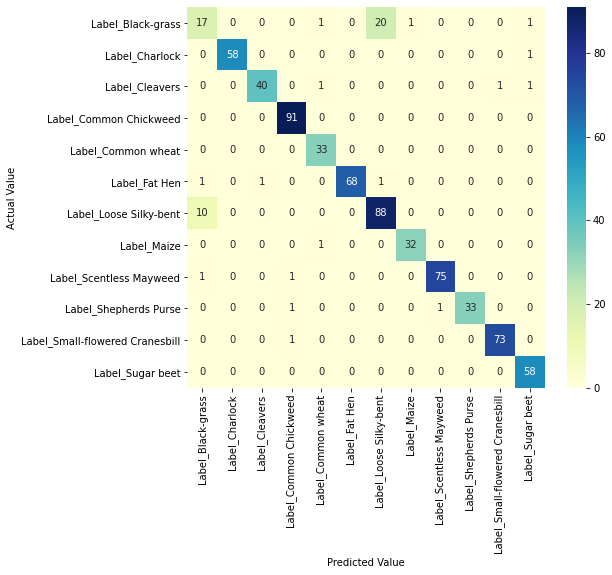

In [51]:
show_confusion_matrix(y2_true, y2_pred)

In [52]:
print(classification_report(y2_true, y2_pred))

              precision    recall  f1-score   support

           0       0.59      0.42      0.49        40
           1       1.00      0.98      0.99        59
           2       0.98      0.93      0.95        43
           3       0.97      1.00      0.98        91
           4       0.92      1.00      0.96        33
           5       1.00      0.96      0.98        71
           6       0.81      0.90      0.85        98
           7       0.97      0.97      0.97        33
           8       0.99      0.97      0.98        77
           9       1.00      0.94      0.97        35
          10       0.99      0.99      0.99        74
          11       0.95      1.00      0.97        58

    accuracy                           0.94       712
   macro avg       0.93      0.92      0.92       712
weighted avg       0.93      0.94      0.93       712



- Accuracy is improved to 0.94 from 0.89.
- Only one category (class 0) gains recall below 0.70. Other categories all obtain recalls greater than 0.90.

# Conclusion
- First, we build a basic model m1. Directly applying this model on our data, we get test accuracy of 0.80. Overfitting exists between train and validation/ test set and 3 categories obtain recall below 0.70.
- Data augmentation is a effective technique to reduce overfitting. After training with artificial data on the same model, there's no more overfitting. Test accuracy for model m2 is improved to 0.89. The number of categories with recall lower than 0.70 is reduced to 1. 
- Finally, implement transfer learning with InceptionV3 and combine it with data augmentation. Test accuracy for model m3 is further improved to 0.94. All categories except one gain recall greater than 0.9.
- Model m3 is the best model. Reviewing the confustion matrix, 50% of class 0 (Black grass) are mistakenly identified as class 6 (Loose silky bent) and 10% of class 6 are mistakenly identified as class 0. The reason may be such two categories look quite alike, which is hard to distinguish from each other even by human eyes.